### Setup

In [1]:
import networkx as nx
import json
import os
import yaml
from textwrap import dedent
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exec(open("/tools/C/nayiri/power/power-analysis/variables.py").read())
exec(open(f"{power_analysis_dir}/util.py").read())

In [4]:
rtl = 'RocketConfig'
my_w = 'towers'
power_level = 'rtl'
my_workloads = riscv_benchmarks.copy()
my_workloads.remove('mm')
my_workloads.remove('rsort')

### Run RTL Sim

In [5]:
hammer_extra_args = f"""export HAMMER_EXTRA_ARGS="-p {vlsi_dir}/nk.yml" """
for w in my_workloads:
    binary = f"export BINARY={workloads[w]['binary_path']}"
    print(f"{hammer_extra_args} && {binary} && make redo-sim-rtl-debug")

export HAMMER_EXTRA_ARGS="-p /tools/C/nayiri/power/chipyard-intech16-apr23/vlsi/nk.yml"  && export BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/dhrystone.riscv && make redo-sim-rtl-debug
export HAMMER_EXTRA_ARGS="-p /tools/C/nayiri/power/chipyard-intech16-apr23/vlsi/nk.yml"  && export BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/median.riscv && make redo-sim-rtl-debug
export HAMMER_EXTRA_ARGS="-p /tools/C/nayiri/power/chipyard-intech16-apr23/vlsi/nk.yml"  && export BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/mt-matmul.riscv && make redo-sim-rtl-debug
export HAMMER_EXTRA_ARGS="-p /tools/C/nayiri/power/chipyard-intech16-apr23/vlsi/nk.yml"  && export BINARY=/tools/B/nayiri/chipyard-tools/riscv-tools-install/riscv64-unknown-elf/share/riscv-tests/benchmarks/mt-vvadd.riscv && make redo-sim-rtl-debug
export H

### Parse RTL Sim Waveforms

In [6]:
'''
cd /tools/C/nayiri/power/power-analysis/fsdb
./scripts/print_headers.py
./scripts/parse_headers.py
./scripts/dump_toggles.py
'''

'\ncd /tools/C/nayiri/power/power-analysis/fsdb\n./scripts/print_headers.py\n./scripts/parse_headers.py\n./scripts/dump_toggles.py\n'

### Get list of module/insts/power

In [7]:
g = nx.DiGraph()

top = 'chiptop' # needs to be lowercase

tmh = {}
tmh_file = f"{vlsi_dir}/generated-src/chipyard.TestHarness.RocketConfig/top_module_hierarchy.json"
with open(tmh_file, 'r') as f:
    tmh = json.load(f)

# inst_gnodes_dict = {}

root = tmh['instance_name']
# only keep DigitalTop (throw out generic IO cells)
children = [i for i in tmh['instances'] if i['module_name'] == 'DigitalTop']
parent_children = [(root, children)]
g.add_node(root, module_name=tmh['module_name'])

while parent_children:
    parent, children = parent_children.pop()
    for child_dict in children:
        child = child_dict['instance_name']
        child_path = parent+'/'+child

        g.add_node(child_path, module_name=child_dict['module_name'])
        g.add_edge(parent, child_path)

        parent_children.append((child_path, child_dict['instances']))
print(g)
print('Graph is a tree?', nx.is_tree(g))

DiGraph with 758 nodes and 757 edges
Graph is a tree? True


In [8]:
'''
execute parse_module_tree.ipynb
'''

'\nexecute parse_module_tree.ipynb\n'

### Create dict of module/insts/power

In [10]:
# largest_insts = []
# largest_modules = set()
module_inst_dict = {}  # {module: inst}
inst_module_dict = {}  # {inst: module}
infile = f"{power_analysis_dir}/out/module_power.rpt"
with open(infile,'r') as f:
    lines = f.readlines()
for line in lines[1:]:
    words = line.split()
    if len(words) != 3: continue
    power = float(words[0])
    module = words[1]
    inst = words[2]
    if module not in module_inst_dict: 
        module_inst_dict[module] = {}
        module_inst_dict[module]['power'] = power
        module_inst_dict[module]['insts'] = []
    module_inst_dict[module]['insts'].append(inst)
    inst_module_dict[inst] = module

In [11]:
tmh = {}
tmh_file = f"{vlsi_dir}/generated-src/chipyard.TestHarness.RocketConfig/top_module_hierarchy.json"
with open(tmh_file, 'r') as f:
    tmh = json.load(f)
root = tmh['instance_name']
inst_module_dict = {root: root}
# only keep DigitalTop (throw out generic IO cells)
children = [i for i in tmh['instances'] if i['module_name'] == 'DigitalTop']
parent_children = [(root, children)]
while parent_children:
    parent, children = parent_children.pop()
    for child_dict in children:
        child = child_dict['instance_name']
        child_path = parent+'/'+child
        inst_module_dict[child_path] = child_dict['module_name']
        parent_children.append((child_path, child_dict['instances']))

### Run Hammer + Joules to get per-module power traces
Generate Hammer YAML Config + Commands to create one report per module instance, 
where there may be multiple instances per module

In [12]:
exec(open("/tools/C/nayiri/power/power-analysis/variables.py").read())

script = f"{vlsi_dir}/run-power.sh"
fscript = open(script, 'w')
fscript.write("""\
#!/bin/bash
set -x #echo on
""")

for w in my_workloads:
    profile_dir = get_module_profile_dir(w)
    waveform_path = get_waveform_path(w)
    cfg = {
        'power.inputs.saifs': [],
        'power.inputs.waveforms': [],
        'power.inputs.report_configs': [
          {
            'waveform_path': waveform_path,
            'module': 'chiptop',
            'toggle_signal': '/ChipTop/clock_clock',
            'start_time': '100ns',
            'num_toggles': 100,
            'output_formats': [
              'report',
              'plot_profile'
            ]
          }
        ],
        'power.joules.version': '211',
        'power.voltus.version': '211_ISR3',
        'vlsi.core.power_tool': 'joules'
    }
    report_cfgs = []

    waveform_name = os.path.basename(waveform_path).split('.')[0]
    for module in module_inst_dict:
        for i,inst in enumerate(module_inst_dict[module]['insts']):
            report_cfg = {
                'waveform_path': waveform_path,
                'inst': inst,
                'toggle_signal': '/ChipTop/clock_clock',
                'start_time': f'{N_CYCLES}ns',
                'num_toggles': N_CYCLES,
                'report_name': f'{profile_dir}/module_{module}-inst_{i}-toggles_{N_CYCLES}',
                'output_formats': [
                'plot_profile'
                ]
            }
            report_cfgs.append(report_cfg.copy())
    cfg['power.inputs.report_configs'] += report_cfgs
    yaml_config_file = get_hammer_yaml_file(w)
    # print(f"Writing configs to {yaml_config_file}")
    with open(yaml_config_file,'w') as f:
        yaml.dump(cfg, f, sort_keys=False)
    hammer_extra_args = f"""export HAMMER_EXTRA_ARGS="-p {vlsi_dir}/nk.yml -p {yaml_config_file}" """
    cmd = f"echo {waveform_name} && make redo-power-rtl"
    cmd= f"""bsub -q bora "{cmd}" """
    to_print = dedent(f"""
    {hammer_extra_args}
    {cmd}
    """).strip()
    # print(to_print)
    fscript.write(to_print)
    fscript.write("\nsleep 10\n")
   
fscript.close()
print(f"Wrote script to {script}")

Wrote script to /tools/C/nayiri/power/chipyard-intech16-apr23/vlsi/run-power.sh


### Get signal names + idcodes within each module
NOTE: we currently only get leaf signals, NOT signals nested within another module in an instance
```
module_inst_dict = {
    modA: {
        'area': 123,
        'insts': [inst0, inst1, ...]
        inst0: [
            (signal_name, idcode)
            ...
        ]
        inst1: ...
    }
    modB: ...

}
```

In [13]:
inst_hier = []
signal_id_dict = {}
id_signal_dict = {}
module = ''
my_w = 'towers'
w_fsdb_idcodes = set(get_fsdb_idcodes(my_w))
module_insts_sigids_dict = {m: {} for m in module_inst_dict}
with open(get_fsdb_header_path(my_w), 'r') as f:
    in_module = False
    for line in f.readlines():
        words = line.split()
        if len(words) < 1: continue
        if words[0] == '<Scope>':
            name=words[1].replace('name:','')
            inst_hier.append(name)
            inst = '/'.join(inst_hier).replace('TestDriver/testHarness/chiptop', 'ChipTop')
            module = inst_module_dict[inst] if inst in inst_module_dict else "NONE"
            in_module = module in module_inst_dict
            if in_module:
                module_insts_sigids_dict[module][inst] = set()
        elif words[0] == '<Upscope>':
            inst = '/'.join(inst_hier).replace('TestDriver/testHarness/chiptop', 'ChipTop')
            module = inst_module_dict[inst] if inst in inst_module_dict else "NONE"
            in_module = False
            inst_hier.pop(-1)
        elif words[0] == '<Var>':
            if len(words) < 3: continue                
            if in_module:
                signal=words[1]
                idcode=int(words[2])
                if idcode not in w_fsdb_idcodes: 
                    continue
                module_insts_sigids_dict[module][inst].add((signal, idcode))

In [14]:
module_signal_idcodes_dict = {}
for module in module_insts_sigids_dict:
    ''' get signals+idcodes for first instance of module
        since we need columns to correspond to the same signal
        across different time slices
    '''
    module_insts = list(module_insts_sigids_dict[module].keys())
    inst0 = module_insts[0]
    signal_idcode_list = module_insts_sigids_dict[module][inst0]
    # signals0 = sorted([s for s,_ in signal_idcode_list])
    signal_idcode_dict = {s:[id] for s,id in signal_idcode_list}
    for inst in module_insts[1:]:
        signal_idcode_list = module_insts_sigids_dict[module][inst]
        for s,id in signal_idcode_list:
            if s in signal_idcode_dict: signal_idcode_dict[s].append(id)
            else: print(module, inst, s)
    signal_idcode_dict = {s:ids for s,ids in signal_idcode_dict.items() if len(ids) == len(module_insts_sigids_dict[module])}
    module_signal_idcodes_dict[module] = signal_idcode_dict.copy()

In [ ]:
exec(open("/tools/C/nayiri/power/power-analysis/util.py").read())
toggles, jpower, workload_borders = get_workloads_toggles_jpower(my_workloads)
my_workloads = list(workload_borders.keys())
toggles.shape, jpower.shape

In [16]:
exec(open("/tools/C/nayiri/power/power-analysis/util.py").read())
idcode_idx_dict = {int(idcode):idx for idx,idcode in enumerate(get_fsdb_idcodes(my_w))}
len(idcode_idx_dict)

29929

### Get toggles for each module

In [17]:
module_toggles_dict = {}
for module,s_ids in module_signal_idcodes_dict.items():
    module_array = np.array(list(s_ids.values()))  # signal idcodes
    module_toggles = np.ndarray((0,module_array.shape[0])) # shape = 0 x # signals
    # for slice in range(len(module_array[0,:])):
    for slice in range(module_array.shape[1]):
        slice_idcodes = module_array[:,slice]
        slice_idxs = [idcode_idx_dict[id] for id in slice_idcodes if id in idcode_idx_dict]
        slice_module_toggles = toggles[:,slice_idxs]
        module_toggles = np.concatenate((module_toggles, slice_module_toggles), axis=0)
    # print(module_toggles.shape)
    module_toggles_dict[module] = module_toggles


In [18]:
for m in module_toggles_dict:
    print(m, module_toggles_dict[m].shape) #, len(module_jpower_dict[m]))

TLDebugModuleInner (12220, 641)
CSRFile (12220, 901)
Rocket (12220, 821)
data_arrays_0_ext (12220, 584)
ICache (12220, 128)
Frontend (12220, 258)
SourceD (12220, 219)
table_combMem (12220, 522)
ShiftQueue (12220, 105)
rf_combMem (12220, 45)
PTW (12220, 460)
ChipTop (12220, 177)
BTB (12220, 360)
DCache (12220, 1820)
ALU (12220, 18)
TLXbar (12220, 232)
cc_dir_ext (12220, 384)
data_combMem_1 (12220, 50)
data_arrays_0_0_ext (24440, 294)
BankedStore (12220, 109)
RVCExpander (12220, 97)
GenericSerializer (12220, 26)
IBuf (12220, 73)
tag_array_ext (12220, 214)
TLCacheCork (12220, 151)
MSHR (85540, 226)
TLToAXI4 (12220, 157)
Scheduler (12220, 657)
TLAtomicAutomata_1 (12220, 195)
SinkA (12220, 60)
DigitalTop (12220, 565)
ram_combMem_1 (24440, 266)
FPU (12220, 186)
TLB_1 (12220, 828)
TLXbar_5 (12220, 287)
tag_array_0_ext (12220, 206)
GenericDeserializer (12220, 28)
ListBuffer (12220, 43)
TLXbar_2 (12220, 75)
Queue_30 (12220, 27)
data_combMem (12220, 43)
HellaPeekingArbiter (12220, 126)
TLUART (1

In [19]:
# # add signals of all instances within submodule
# # avoid doing this if just top-level signals work!!
# instpaths = [n for n in g.nodes if g.out_degree(n) == 0]
# while instpaths:
#     instpath = instpaths.pop(0)
#     if instpath not in inst_module_dict: continue
#     module = inst_module_dict[instpath]
#     m_toggles = module_toggles_dict[module]
#     # if module not in module_insts_sigids_dict: continue
#     if module not in module_toggles_dict: continue
#     # # print(module, instpath)
#     # sigids = module_insts_sigids_dict[module][instpath]
#     # for parent_inst, _ in g.in_edges(instpath):
#     #     if parent_inst not in inst_module_dict: continue
#     #     parent_module = inst_module_dict[parent_inst]
#     #     if parent_module not in module_insts_sigids_dict: continue
#     #     # print(instpath, parent_inst)
#     #     # print(module_insts_sigids_dict[parent_module].keys())
#     #     module_insts_sigids_dict[parent_module][parent_inst].update(sigids)
#     #     instpaths.append(parent_inst)

### Get power trace for each module

In [21]:
exec(open("/tools/C/nayiri/power/power-analysis/util.py").read())

module_jpower_dict = {m: [] for m in module_toggles_dict}

cfgs = {}
i = 0
for w in my_workloads:
    with open(get_hammer_yaml_file(w),'r') as f:
        cfgs = yaml.safe_load(f)
    for report_cfg in cfgs['power.inputs.report_configs']:
        if 'inst' not in report_cfg: continue
        inst = report_cfg['inst']
        module = inst_module_dict[inst]
        report_path = report_cfg['report_name'] + '.png.data'
        _, w_m_jpower = read_profile_file(w, profile_file=report_path)
        len_w_toggles = workload_borders[w][1]-workload_borders[w][0]
        if len(w_m_jpower) == 0: continue
        if len(w_m_jpower) < len_w_toggles: 
            print(w, module, f'{len(w_m_jpower)} vs {len_w_toggles}')
            continue
        assert(len(w_m_jpower) >= len_w_toggles), (w, module, f'{len(w_m_jpower)} vs {len_w_toggles}')
        
        module_jpower_dict[module] += w_m_jpower[:len_w_toggles]
    # print([len(module_jpower_dict[m]) for m in module_jpower_dict if len(module_jpower_dict[m]) > 0])
    
    # if w in workload_borders: prev_border = workload_borders[w]
        
# [len(module_jpower_dict[m]) for m in module_jpower_dict if len(module_jpower_dict[m]) > 0]

In [22]:
[len(module_jpower_dict[m]) for m in module_jpower_dict if len(module_jpower_dict[m]) > 0]

[12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 24440,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 85540,
 12220,
 12220,
 12220,
 12220,
 12220,
 24440,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 24440,
 12220,
 293280,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 24440,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 12220,
 48880,
 12220,
 12220]

In [23]:
module_toggles_dict = {m:i for m,i in module_toggles_dict.items() if len(module_jpower_dict[m]) > 0}
module_jpower_dict = {m:i for m,i in module_jpower_dict.items() if len(module_jpower_dict[m]) > 0}

In [24]:
module_inst_dict['DCache']['insts']

['ChipTop/system/tile_prci_domain/tile_reset_domain_tile/dcache']

#### Dump data to files

In [25]:
exec(open(f"{power_analysis_dir}/util.py").read())
summary_dict = {}
summary_dict['workloads'] = my_workloads
summary_dict['modules'] = []
for m in module_toggles_dict:
    np.save(get_module_data_path(m,'toggles'), module_toggles_dict[m])
    np.save(get_module_data_path(m,'jpower'),  module_jpower_dict[m])
    summary_dict['modules'].append(m)


with open(get_module_data_path(type='summary'),'w') as f:
    json.dump(summary_dict,f,indent=4)

### Fit linear model to each module's data

In [26]:
module_jpower_dict.keys()

dict_keys(['TLDebugModuleInner', 'CSRFile', 'Rocket', 'data_arrays_0_ext', 'ICache', 'Frontend', 'SourceD', 'table_combMem', 'ShiftQueue', 'rf_combMem', 'PTW', 'ChipTop', 'BTB', 'DCache', 'ALU', 'TLXbar', 'cc_dir_ext', 'data_combMem_1', 'data_arrays_0_0_ext', 'BankedStore', 'RVCExpander', 'GenericSerializer', 'IBuf', 'tag_array_ext', 'TLCacheCork', 'MSHR', 'TLToAXI4', 'Scheduler', 'TLAtomicAutomata_1', 'SinkA', 'DigitalTop', 'ram_combMem_1', 'FPU', 'TLB_1', 'TLXbar_5', 'tag_array_0_ext', 'GenericDeserializer', 'ListBuffer', 'TLXbar_2', 'Queue_30', 'data_combMem', 'HellaPeekingArbiter', 'TLUART', 'ram_combMem_20', 'PMPChecker_2', 'AsyncResetSynchronizerPrimitiveShiftReg_d3_i0', 'MulDiv', 'next_combMem_1', 'UARTRx', 'TLAtomicAutomata', 'TLXbar_6', 'SourceC', 'PeripheryBus_1', 'head_combMem_1', 'CLINT', 'HellaCacheArbiter', 'tail_combMem_1', 'Directory', 'TLXbar_4', 'TLXbar_8', 'SinkC', 'NonSyncResetSynchronizerPrimitiveShiftReg_d3', 'ram_combMem_6', 'ListBuffer_2', 'ListBuffer_1', 'Async

(-1.4932272475979, 6.5967212465)

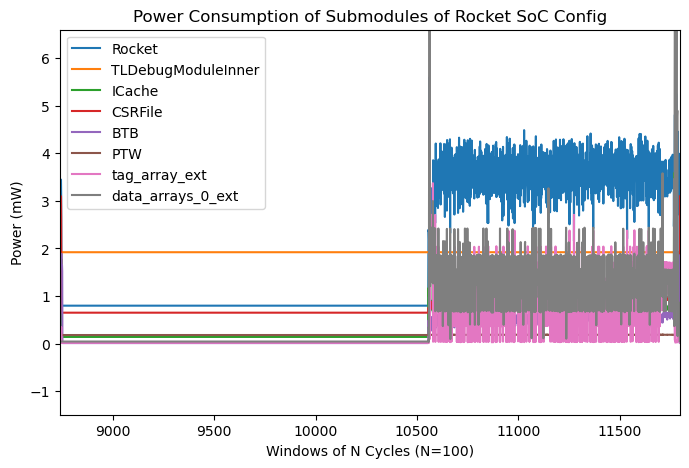

In [37]:
plt.figure(figsize=(8,5))
i = 6
plt.xlim(workload_borders[my_workloads[i]])
for module in ['Rocket',
               'TLDebugModuleInner',
               'ICache',
               #'ALU',
               #'FPU',
            #    'MulDiv',
               #'CLINT',
                'CSRFile',
                'BTB',
                'PTW',
               'tag_array_ext',
               'data_arrays_0_ext',
               ]:
    plt.plot(module_jpower_dict[module], label=module) #, linewidth=2)
# plt.xlim(0,35000)
plt.legend(loc='upper left')#, bbox_to_anchor=(1,1))
plt.xlabel(f'Windows of N Cycles (N={N_CYCLES})')
plt.title('Power Consumption of Submodules of Rocket SoC Config')
plt.ylabel('Power (mW)')
# w = 'median'
plt.ylim(top=max(module_jpower_dict['Rocket']))
# plt.xlim(workload_borders[w],workload_borders[my_workloads[my_workloads.index(w)+1]])

In [ ]:
import numpy as np
import sklearn.linear_model
import sklearn.cluster
import sklearn.preprocessing
import math
import matplotlib.pyplot as plt
import sklearn.decomposition

In [ ]:
exec(open("/tools/C/nayiri/power/power-analysis/util.py").read())
i = 0
module_regr_dict = {}
for module in module_toggles_dict:
    m_toggles = module_toggles_dict[module]
    m_jpower = module_jpower_dict[module]
    # m_toggles, m_jpower = get_workload_toggles_jpower(m_toggles, m_jpower, list(workload_borders.values()), 3)
    if m_toggles.shape[0] != len(m_jpower): 
        print(f"Skipping {module}: {m_toggles.shape[0]} toggles vs {len(m_jpower)} jpower")
        continue
    # scaler_X = sklearn.preprocessing.StandardScaler()
    # m_toggles_scaled = scaler_X.fit_transform(m_toggles)
    pca = sklearn.decomposition.PCA(n_components=min(50,m_toggles.shape[1]))
    m_toggles_s = pca.fit_transform(m_toggles)
    # m_toggles_s = m_toggles_scaled
    print(i, module.ljust(22), end='  ')
    regr, r2, nrmse = fit(m_toggles_s, m_jpower, type='elasticnetcv',
                max_iter=200,
                return_r2=True, return_nrmse=True)
    module_regr_dict[module] = {}
    module_regr_dict[module]['regr'] = regr
    module_regr_dict[module]['r2'] = r2
    module_regr_dict[module]['nrmse'] = nrmse
    module_regr_dict[module]['toggles_s_pca'] = m_toggles_s
    # m_power_pred = predict(m_toggles_s, m_jpower, regr)
    # plot_power(m_jpower, m_power_pred,
    #             workload_borders=workload_borders, 
    #             y_first=False, title=module)
    i += 1
    # if i > 30: break


0 TLDebugModuleInner      R^2 = 0.0, NRMSE = 3%
1 CSRFile                 R^2 = 0.61, NRMSE = 18%
2 Rocket                  R^2 = 0.97, NRMSE = 13%
3 data_arrays_0_ext       R^2 = 0.92, NRMSE = 50%
4 ICache                  R^2 = 0.94, NRMSE = 20%
5 Frontend                R^2 = 0.93, NRMSE = 20%
6 SourceD                 R^2 = 0.95, NRMSE = 9%
7 table_combMem           R^2 = 0.84, NRMSE = 49%
8 ShiftQueue              R^2 = 0.98, NRMSE = 12%
9 rf_combMem              R^2 = 0.95, NRMSE = 23%
10 PTW                     R^2 = 0.79, NRMSE = 2%
11 ChipTop                 R^2 = 0.86, NRMSE = 21%
12 BTB                     R^2 = 0.85, NRMSE = 41%
13 DCache                  R^2 = 0.97, NRMSE = 28%
14 ALU                     R^2 = 0.97, NRMSE = 23%
15 TLXbar                  R^2 = 0.79, NRMSE = 5%
16 cc_dir_ext              R^2 = 0.8, NRMSE = 35%
17 data_combMem_1          R^2 = 0.74, NRMSE = 38%
18 data_arrays_0_0_ext     R^2 = 0.0, NRMSE = 107%
19 BankedStore             R^2 = 0.96, NRMSE = 

In [ ]:
r2_modules = sorted(zip([module_regr_dict[m]['r2'] for m in module_regr_dict], module_regr_dict.keys()))
i = 0
for _, module in r2_modules:
    if 'regr' not in module_regr_dict[module]: continue
    regr = module_regr_dict[module]['regr']
    m_toggles = module_toggles_dict[module]
    m_jpower = module_jpower_dict[module]

    m_power_pred = predict(module_regr_dict[module]['toggles_s_pca'], m_jpower, regr)
    plot_power(m_jpower, m_power_pred,
                workload_borders=workload_borders, 
                y_first=False, title=module)
    plt.ylim(0,max(max(m_jpower), 0.1))
    i += 1
    if i > 20: break


TypeError: cannot unpack non-iterable ElasticNetCV object